# Демонстрация автоматического расчета shap

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, AutoTrees, base_pipe, PlotShap, BalanceCover

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.6


In [5]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

In [9]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [10]:
# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(
    eta=0.01,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth = 6,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [11]:
xgb_model.fit(new_X_train, y_train);

[02:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 1. Кастомная метрика

In [12]:
df_train = pd.DataFrame()
df_train['target'] = y_train
df_train['proba'] = xgb_model.predict_proba(new_X_train)[:, 1]
df_train = df_train.sort_values('proba', ascending=False).reset_index(drop=True)

df_train.head(2)

,target,proba
0,1,0.991804
1,1,0.989071


In [13]:
df_valid = pd.DataFrame()
df_valid['target'] = y_valid
df_valid['proba'] = xgb_model.predict_proba(new_X_valid)[:, 1]
df_valid = df_valid.sort_values('proba', ascending=False).reset_index(drop=True)

df_valid.head(2)

,target,proba
0,1,0.991994
1,1,0.989649


### 1.1 TRAIN - Накапливаемые статистики

In [14]:
metr_train = BalanceCover(df_train, target='target')

Всего записей в выборке:  623
Всего таргетов в выборке:  239


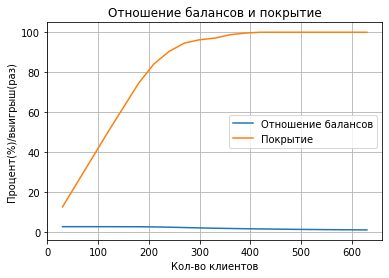

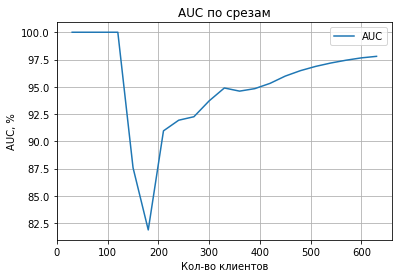

In [15]:
metr_train.calc_scores(30, df_train.shape[0])

metr_train.sample_describe()
metr_train.plot_scores()

In [16]:
metr_train.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,30,100.000000,12.552301,38.362761,2.606695,100.000000
1,0,60,60,100.000000,25.104603,38.362761,2.606695,100.000000
2,0,90,90,100.000000,37.656904,38.362761,2.606695,100.000000
3,0,120,120,100.000000,50.209205,38.362761,2.606695,100.000000
4,0,150,149,99.333333,62.343096,38.362761,2.589317,87.583893
5,0,180,178,98.888889,74.476987,38.362761,2.577731,81.882022
6,0,210,201,95.714286,84.100418,38.362761,2.494979,90.961857
7,0,240,216,90.000000,90.376569,38.362761,2.346025,91.936728
8,0,270,226,83.703704,94.560669,38.362761,2.181900,92.256637
9,0,300,230,76.666667,96.234310,38.362761,1.998466,93.708075


### 1.2 TRAIN - Статистики по бакетам

Всего записей в выборке:  623
Всего таргетов в выборке:  239


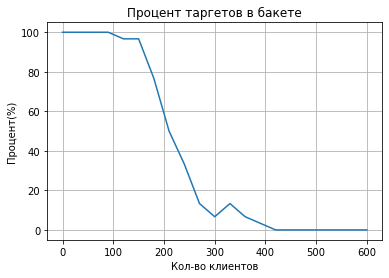

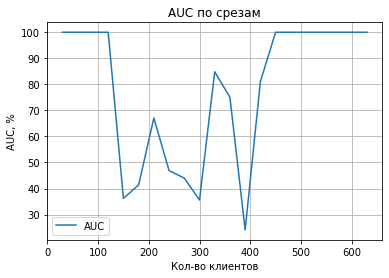

In [17]:
metr_train.calc_scores_2(30, df_train.shape[0])

metr_train.sample_describe()
metr_train.plot_scores_2()

In [18]:
metr_train.output2

,start_bucket,end_bucket,target_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,30,100.000000,12.552301,38.362761,2.606695,100.000000
1,30,60,30,100.000000,12.552301,38.362761,2.606695,100.000000
2,60,90,30,100.000000,12.552301,38.362761,2.606695,100.000000
3,90,120,30,100.000000,12.552301,38.362761,2.606695,100.000000
4,120,150,29,96.666667,12.133891,38.362761,2.519805,36.206897
5,150,180,29,96.666667,12.133891,38.362761,2.519805,41.379310
6,180,210,23,76.666667,9.623431,38.362761,1.998466,67.080745
7,210,240,15,50.000000,6.276151,38.362761,1.303347,46.888889
8,240,270,10,33.333333,4.184100,38.362761,0.868898,44.000000
9,270,300,4,13.333333,1.673640,38.362761,0.347559,35.576923


### 1.3 TEST - Накапливаемые статистики

In [19]:
metr_valid = BalanceCover(df_valid, target='target')

Всего записей в выборке:  268
Всего таргетов в выборке:  103


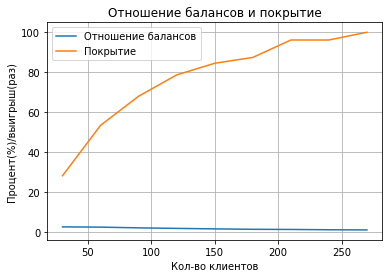

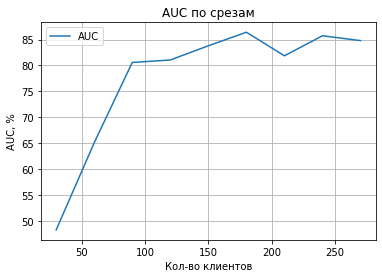

In [20]:
metr_valid.calc_scores(30, df_valid.shape[0])

metr_valid.sample_describe()
metr_valid.plot_scores()

In [21]:
metr_valid.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,29,96.666667,28.155340,38.432836,2.515210,48.275862
1,0,60,55,91.666667,53.398058,38.432836,2.385113,65.090909
2,0,90,70,77.777778,67.961165,38.432836,2.023732,80.571429
3,0,120,81,67.500000,78.640777,38.432836,1.756311,81.054131
4,0,150,87,58.000000,84.466019,38.432836,1.509126,83.789454
5,0,180,90,50.000000,87.378641,38.432836,1.300971,86.401235
6,0,210,99,47.142857,96.116505,38.432836,1.226630,81.859132
7,0,240,99,41.250000,96.116505,38.432836,1.073301,85.718891
8,0,270,103,38.148148,100.000000,38.432836,0.992593,84.786702


### 1.4 TEST - Статистики по бакетам

Всего записей в выборке:  268
Всего таргетов в выборке:  103


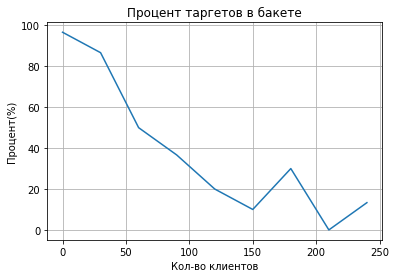

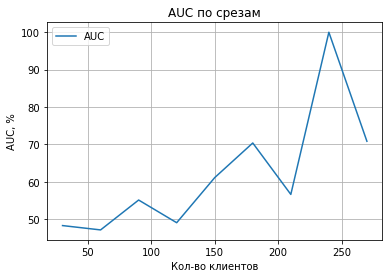

In [22]:
metr_valid.calc_scores_2(30, df_valid.shape[0])

metr_valid.sample_describe()
metr_valid.plot_scores_2()

In [23]:
metr_valid.output2

,start_bucket,end_bucket,target_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal,auc
0,0,30,29,96.666667,28.155340,38.432836,2.515210,48.275862
1,30,60,26,86.666667,25.242718,38.432836,2.255016,47.115385
2,60,90,15,50.000000,14.563107,38.432836,1.300971,55.111111
3,90,120,11,36.666667,10.679612,38.432836,0.954045,49.043062
4,120,150,6,20.000000,5.825243,38.432836,0.520388,61.111111
5,150,180,3,10.000000,2.912621,38.432836,0.260194,70.370370
6,180,210,9,30.000000,8.737864,38.432836,0.780583,56.613757
7,210,240,0,0.000000,0.000000,38.432836,0.000000,100.000000
8,240,270,4,13.333333,3.883495,38.432836,0.346926,70.833333


## 2. Использование библиотеки

In [24]:
# задаем класс
c_shap = PlotShap(model=xgb_model, sample=new_X_train)
# обучаем
c_shap.fit_shap()

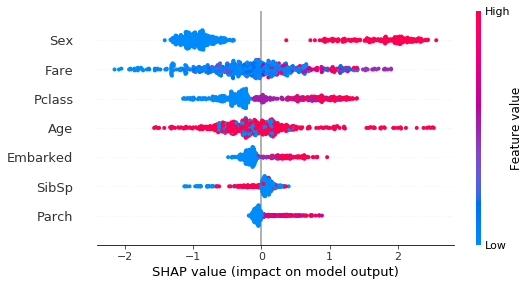

In [25]:
c_shap.create_plot_shap(plot_type='dot', number_features=30)

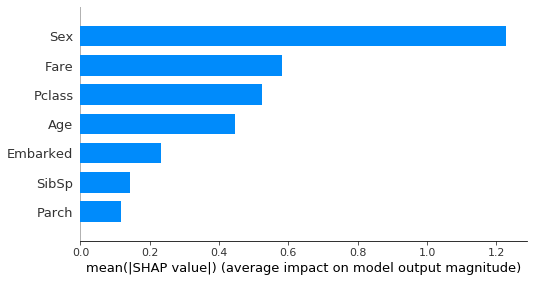

In [26]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [27]:
result = c_shap.get_table_shap()
result

,col_name,imp_shap
0,Sex,1.226701
1,Fare,0.580397
2,Pclass,0.522742
3,Age,0.446026
4,Embarked,0.231003
5,SibSp,0.141932
6,Parch,0.117993


## 3. График в нужном порядке
Часто бывают такие ситуации, что нужно в нужном порядке получить график. Например, для презентации.    
Сейчас фреймворк позволяет это сделать.

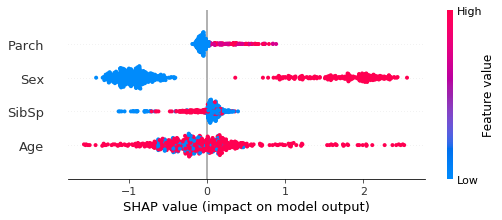

In [28]:
features = ['Parch', 'Sex', 'SibSp', 'Age']
c_shap.create_feature_shap(features)

## 4. HTML отчет

In [29]:
c_shap.create_shap_report(path_base='./shap_report')

Директория существует
